In [1]:
import xarray as xr

from pydantic import BaseModel, constr, field_validator, ValidationInfo, model_validator
from datetime import datetime
from typing import List, Any, Optional
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
class HydCal(BaseModel):
    refdes: constr(min_length=27, max_length=27)
    deployment: str
    asset_id: constr(min_length=17, max_length=17)
    model: str
    sn: int
    cal_date: datetime
    frequencies: List[float]
    sens: List[float] = None
    sens0: List[float] = None
    sens90: List[float] = None
    ds: Any = None
    rca_bb_offset: float = 128.9

    @model_validator(mode="after")
    def convert_date(self):
        """Convert cal_date to an ISO 8601 string immediately after instantiation."""
        self.cal_date = self.cal_date.strftime("%Y-%m-%dT%H:%M:%S.%fZ")
        return self  # Must return self in a model validator

    @field_validator("frequencies", mode="before")
    @classmethod
    def convert_freqs(cls, values):
        """Convert kHz to Hz by multiplying each element by 1000."""
        return [v * 1000 for v in values]

    @field_validator("sens")
    @classmethod
    def check_lengths(cls, v, info):
        if "frequencies" in info.data and len(v) != len(info.data["frequencies"]):
            raise ValueError("sens and frequencies must be the same length")
        return v

    def make_ndarray(self):
        if self.sens is not None:
            print("creating only a single sensitivity data var")
            self.ds = xr.Dataset(
            data_vars={
                "sensitivity": (["frequency"], self.sens),
            },
            coords={
                "frequency": self.frequencies,
            },
            attrs={
                "asset_id": self.asset_id,
                "model": self.model,
                "serial_number": self.sn,
                "calibration_date": self.cal_date,
            }
            )
        elif self.sens0 is not None and self.sens90 is not None:
            print("creating both 0 and 90 degree sensitivities")
            self.ds = xr.Dataset(
            data_vars={
                "sensitivity_0": (["frequency"], self.sens0),
                "sensitivity_90": (["frequency"], self.sens90),
            },
            coords={
                "frequency": self.frequencies,
            },
            attrs={
                "asset_id": self.asset_id,
                "model": self.model,
                "serial_number": self.sn,
                "calibration_date": self.cal_date,
            }
            )
            

    def save_cal(self):
        self.ds.to_netcdf(f"../metadata/cals/{refdes}_{deployment}.nc", mode="w")

    def save_correction_cal(self):
        if self.sens is not None:
            self.ds["sensitivity"] = self.ds["sensitivity"] + self.rca_bb_offset 
        elif self.sens0 is not None and self.sens90 is not None:
            self.ds["sensitivity"] = (self.ds["sensitivity_0"] + self.ds["sensitivity_90"]) / 2
            self.ds["sensitivity"] = self.ds["sensitivity"] + self.rca_bb_offset 

        self.ds.to_netcdf(f"../metadata/rca_correction_cals/{refdes}_{deployment}.nc", mode="w")
        
        

In [3]:
refdes = "RS01SLBS-LJ01A-09-HYDBBA102"
deployment = "6"

In [4]:
asset_id = "ATAPL-58324-00011" #
model = "SB35-ETH" #
sn = 1389 #
cal_date = datetime(2023, 3, 8) #

frequency = [
    0.0,
    10.0, #
    20.1, #
    30.1, #
    40.2, #
    50.2, #
    60.2, #
    70.3, #
    80.3, #
    90.4, #
    100.4, #
    110.4, #
    120.5, #
    130.5, #
    140.5, #
    150.6, #
    160.6, #
    170.7, #
    180.7, #
    190.7, #
    200.0 #
]

sens0 = [
    -168.7, # 
    -168.7, #
    -170.7, #
    -171.1, #
    -169.0, #
    -170.2, #
    -170.2, #
    -170.4, #
    -171.6, #
    -171.6, #
    -171.7, #
    -171.9, #
    -170.5, #
    -169.6, #
    -168.4, #
    -168.2, #
    -165.8, #
    -166.2, #
    -168.3, #
    -173.4, #
    -173.6 #
]

sens90 = [
    -168.8, # 
    -168.8, #
    -170.9, #
    -171.2, #
    -169.4, #
    -170.6, #
    -169.8, #
    -170.0, #
    -171.0, #
    -171.9, #
    -171.5, #
    -170.5, #
    -171.1, #
    -169.7, #
    -169.2, #
    -166.3, #
    -164.9, #
    -165.9, #
    -168.7, #
    -171.1, #
    -176.7 #
]

In [5]:
hyd = HydCal(
    refdes=refdes,
    deployment=deployment,
    asset_id=asset_id,
    model=model,
    sn=sn,
    cal_date=cal_date,
    frequencies = frequency,
    #sens=sens,
    sens0=sens0,
    sens90=sens90,
    )

hyd.make_ndarray()

creating both 0 and 90 degree sensitivities


In [6]:
hyd.cal_date

'2019-12-06T00:00:00.000000Z'

In [7]:
hyd.ds.sensitivity.plot()  # Plot the DataArray

AttributeError: 'Dataset' object has no attribute 'sensitivity'

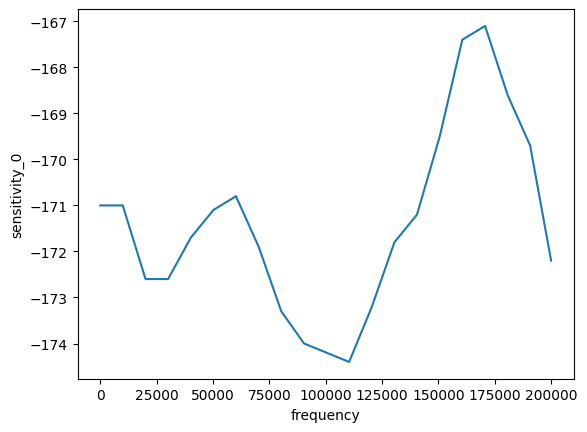

In [8]:
hyd.ds["sensitivity_0"].plot()  # Plot the DataArray

In [9]:
hyd.save_cal()
hyd.save_correction_cal()

In [10]:
test = xr.open_dataset(f"../metadata/rca_correction_cals/{refdes}_{deployment}.nc")

In [11]:
test.sensitivity.values

array([-41.95, -41.95, -43.6 , -43.6 , -42.85, -43.  , -42.3 , -43.1 ,
       -44.75, -45.65, -45.85, -46.45, -45.1 , -43.7 , -42.85, -40.8 ,
       -38.9 , -39.1 , -41.1 , -42.6 , -45.1 ])

In [12]:
test

<xarray.Dataset>
Dimensions:         (frequency: 21)
Coordinates:
  * frequency       (frequency) float64 0.0 1e+04 2.01e+04 ... 1.907e+05 2e+05
Data variables:
    sensitivity_0   (frequency) float64 ...
    sensitivity_90  (frequency) float64 ...
    sensitivity     (frequency) float64 -41.95 -41.95 -43.6 ... -42.6 -45.1
Attributes:
    asset_id:          ATAPL-58324-00005
    model:             SB35-ETH
    serial_number:     1273
    calibration_date:  2019-12-06T00:00:00.000000Z

In [13]:
#product_viz = xr.open_dataset("/Users/joeduprey/repos/ooi-hyd-tools/output/HYDBBA106_20170401.nc")

In [14]:
#product_viz.sensitivity.values

In [10]:
dep4 = xr.open_dataset(f"../metadata/rca_correction_cals/RS03AXBS-LJ03A-09-HYDBBA302_4.nc")

In [16]:
dep4

<xarray.Dataset>
Dimensions:         (frequency: 21)
Coordinates:
  * frequency       (frequency) float64 0.0 1e+04 2.01e+04 ... 1.907e+05 2e+05
Data variables:
    sensitivity_0   (frequency) float64 ...
    sensitivity_90  (frequency) float64 ...
    sensitivity     (frequency) float64 ...

In [17]:
dep4.sensitivity.values

array([-40.85, -40.85, -41.65, -42.05, -41.6 , -44.7 , -43.95, -45.7 ,
       -46.05, -47.4 , -47.1 , -48.6 , -47.75, -46.2 , -44.2 , -41.6 ,
       -38.9 , -38.05, -40.9 , -44.2 , -46.5 ])

In [18]:
dep5 = xr.open_dataset(f"../metadata/rca_correction_cals/RS03AXBS-LJ03A-09-HYDBBA302_5.nc")

In [19]:
dep5.sensitivity.values

array([-39.75, -39.75, -42.  , -41.85, -42.3 , -41.95, -41.65, -40.45,
       -41.8 , -42.8 , -43.9 , -44.55, -42.65, -40.75, -39.5 , -39.15,
       -37.2 , -37.1 , -37.3 , -40.05, -43.35])